# kernel density estimation (KDE)
given a sample from a population (i.e., given data), kernel density estimation is a non-parametric technique to estimate the density of the underlying probability distribution that generated the data.

the technique is [non-parametric](https://en.wikipedia.org/wiki/Nonparametric_statistics) because it does not assume that the distribution takes the shape of any particular (parameterized) probability distribution.

let $f(x)$ be the [probability density function](https://en.wikipedia.org/wiki/Probability_density_function) of a continuous random variable $X$. then, when we sample from this distribution, the probability that $X$ falls in an infinitesimally small interval of width $dx$ centered at $x$ is $f(x)dx$. i.e.
\begin{equation}
    \text{Pr}(x-dx/2<X<x+dx/2)=f(x)dx
\end{equation}

the probability that $x$ falls in an interval $(a, b)$ is the sum of the density in that interval:
\begin{equation}
    \text{Pr}(a<X<b)=\int_a^bf(x)dx
\end{equation}

In typical applications, $f(x)$ is unknown, and all we have is a random sample from the distribution $f(x)$.

Say we have a random sample $x_1, x_2, ..., x_n$ drawn from the probability density $f(x)$, and we want to estimate $f(x_0)$, where $x_0$ is (probably) not in our sample. Kernel density estimation is a principled way to do this. Since we can do this for all $x_0$, we are using the data to estimate the data generating probability distribution.

we are still in the domain of *statistical inference* because we are aiming to make conclusions about the distribution in the population from a random sample.

[here](https://mathisonian.github.io/kde/) is an interactive description of KDE.

In [2]:
import Pkg
Pkg.add("ScikitLearn")

  Updating registry at `C:\Users\Owner\.julia\registries\General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Fetching: [========================================>]  100.0 %.0 %3.1 %>                                  ]  13.2 % % [===========>                             ]  26.7 %34.9 %46.5 % [=======================>                 ]  56.2 %               ]  61.6 %]  83.3 %Fetching: [=====================================>   ]  91.1 %Fetching: [=======================================> ]  97.3 % Resolving package versions...
 Installed ScikitLearnBase ───── v0.5.0
 Installed LegacyStrings ─────── v0.4.1
 Installed Blosc ─────────────── v0.5.1
 Installed CodecZlib ─────────── v0.6.0
 Installed HDF5 ──────────────── v0.12.4
 Installed StaticArrays ──────── v0.11.1
 Installed ScikitLearn ───────── v0.5.1
 Installed NBInclude ─────────── v2.1.0
 Installed FFTW ──────────────── v1.0.1
 Installed FillArrays ────────── v0.7.4
 Installed Mocking ───────────── v0.7.0
 Ins

┌ Warning: failed to extract archive downloaded from https://api.github.com/repos/JuliaData/RData.jl/tarball/cb2b11bbbb18a4317a1db0ef121626945c1db51e
└ @ Pkg.Operations C:\cygwin\home\Administrator\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.2\Pkg\src\Operations.jl:487


 Installed TimeZones ─────────── v0.10.2
 Installed JLD ───────────────── v0.9.1
 Installed GaussianProcesses ─── v0.8.0
 Installed CMakeWrapper ──────── v0.2.3
 Installed GaussianMixtures ──── v0.3.0
 Installed DecisionTree ──────── v0.9.1
 Installed FileIO ────────────── v1.0.7
 Installed DataStructures ────── v0.17.3
 Installed CMake ─────────────── v1.1.2
 Installed TranscodingStreams ── v0.9.5
 Installed EzXML ─────────────── v0.9.4
 Installed RDatasets ─────────── v0.6.1
   Cloning [df47a6cb-8c03-5eed-afd8-b6050d6c41da] RData from https://github.com/JuliaData/RData.jl.git
Fetching: [========================================>]  100.0 %.0 %.5 %==>                                      ]  4.4 % [===>                                     ]  6.9 %>                                   ]  10.5 %]  18.7 %]  22.5 %25.0 %                           ]  31.4 %===============>                         ]  35.5 %6 %]  39.2 % [=================>                       ]  42.1 %7 % [=====================

In [28]:
using CSV
using DataFrames
using PyPlot
using ScikitLearn # machine learning package
using Statistics
using Random
using LaTeXStrings # for L"$x$" to work instead of needing to do "\$x\$"
using Printf

# (optional)change settings for all plots at once, e.g. font size
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 16

16

## the distribution of masses of apples on an orchard

we own an apple orchard in Oregon. we want to know the distribution of the masses of apples so we can (a) estimate our revenues and then (b) make sound investments in our orchard without taking on too much risk. it is prohibitively expensive to measure the mass of every apple, so we instead take a random sample of the apples in our orchard and record their masses. the data is in `apples.csv`.

let $M$ be the mass of an apple on our orchard, a random variable. the idea is that some probability density $f(m)$ governs $M$; that is, when we sample an apple and measure its mass, we are drawing a number from the distribution $f(m)$. we do not know $f(m)$; all we have is a sample of apple masses, $m_1, m_2,...,m_{20}$, in other words, 20 draws from the distribution $f(m)$. we will use this sample to estimate $f(m)$.

In [4]:
df = CSV.read("apples.csv")
first(df, 5)

,mass
,Float64
1,108.205
2,92.1145
3,107.959
4,58.8771
5,100.104


In [5]:
println("# apples sampled: ", nrow(df))
@printf("apple masses range from %.2f g to %.2f g", 
    minimum(df[:, :mass]), maximum(df[:, :mass]))

# apples sampled: 20
apple masses range from 58.88 g to 129.10 g

## histograms are ineffective for estimating probability densities

in a histogram, we partition the set of possible values of the random variable $M$ into discrete bins (usually of equal width) and count the number of samples (in this case, apples) that fall in each bin. we can normalize the height of the bins such that the sum of bin heights times bin widths is one (passing `normed=true` to `hist()` in matplotlib). then, the histogram serves as a (very poor) estimate of the data generating distribution $f(m)$. this estimate is poor because:

* the density estimate is discontinuous (not smooth) at some points, flat within the bins, and exactly zero at many points. the locations of the discontinuities are an artifact of where we choose the bins to be (centers and widths), rather than the underlying probability distribution
* the density estimate depends on where the bins start and end-- especially the drop-offs to exactly zero density
* qualitative features in the data can be hidden depending on shifts in the bins, even if the bins are the same width (we illustrate below)
* as we add dimensions, the number of bins grows exponentially; thus, most bins will be empty in a higher dimensional histogram unless we have a very large number of samples. empty bins => zero density estimate in that bin

to illustrate, make a histogram by partitioning the apple mass interval $[0, 130]$ into 8 equal-width bins. then, shift the bins to the right anywhere from 0 to 50 g. the histogram can reveal/hide bimodality in the distribution of apple masses depending on the offset!

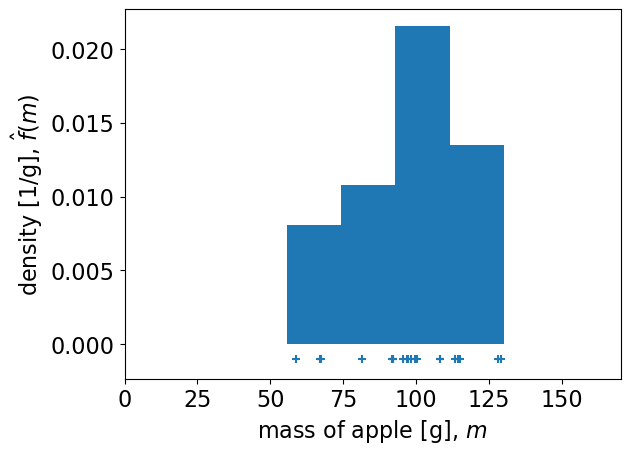

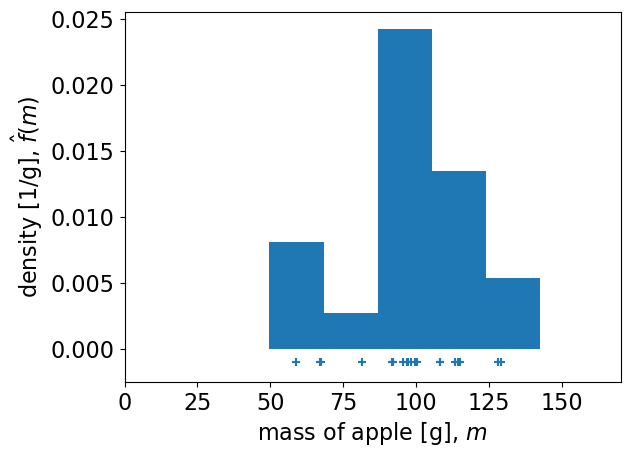

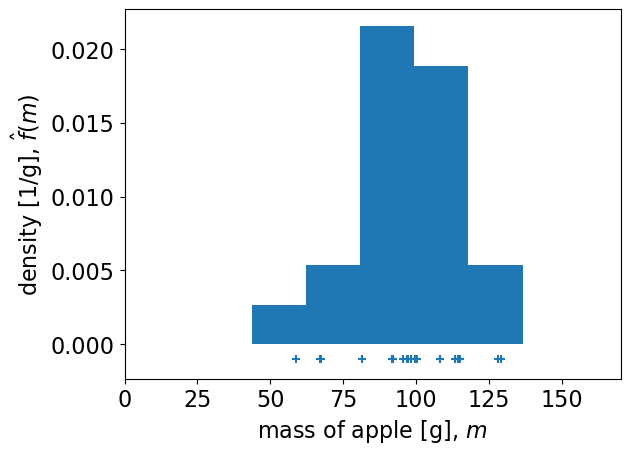

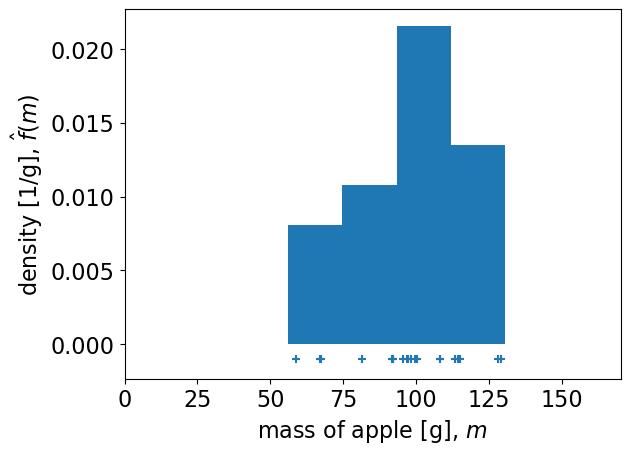

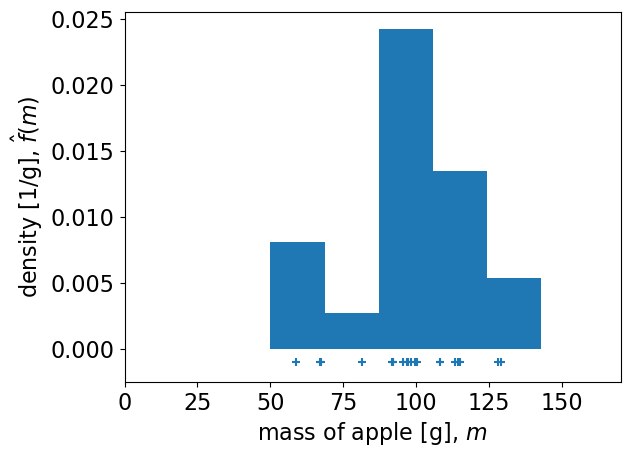

sys:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


In [6]:
# first choice of bins
bins = range(0.0, stop=130.0, length=8)

# offsets to add to the bins to shift them to the right
offsets = range(0.0, stop=50.0, length=5)

for offset in offsets
    figure()
    # normed=true important so the histogram is a density estimate.
    hist(df[:, :mass], bins=bins .+ offset, normed=true)
    xlabel(L"mass of apple [g], $m$")
    ylabel(L"density [1/g], $\hat{f}(m)$") # decorate with hat b/c it's our estimate
    scatter(df[:, :mass], [-0.001 for i = 1:nrow(df)], marker="+")
    xlim([0, 170.0])
end

## kernel function
a kernel function $K(m, m_i)$ is a weighting function that assigns a weight to $m_i$ based on its distance from $m$. such kernel functions are typically indexed by a parameter $\lambda$ that dictates the width of the neighborhood around $m$ where the kernel with $m_i$ is "sizeable" (or, for some kernels, nonzero). the kernel assigns a weight to $m_i$ that decays as its distance from $m$ increases. the kernel is our way of smearing out the data points $m_i$ such that they contribute some to our estimate of the density at $m$. the further a data point $m_i$ is from $m$, the less that data point contributes.

kernel properties:
* symmetry: $K_\lambda(m, m_i)=K_\lambda(m_i, m)$
* non-negative: $K_\lambda(m, m_i) \geq 0$
* like a probability density function: $\int_{-\infty}^\infty K_\lambda(m, m_i) dm = 1$
* decays as $m_i$ gets far from $m$: $\lim_{m_i \rightarrow \pm \infty} K_\lambda(m, m_i)=0$

**the Gaussian kernel**
\begin{equation}
K_\lambda(m,m_i):=\frac{1}{(2\pi\lambda^2)^{d/2}}\exp{\left(-\dfrac{||m-m_i||^2}{2\lambda^2}\right)}
\end{equation}
here, the bandwidth $\lambda$ of the kernel function is the variance of the Gaussian. $d$ is the dimension of the (possibly,) vectors $m$ and $m_i$.


**the Epanechnikov kernel**
\begin{equation}
K_\lambda(m,m_i):=\frac{3}{4\lambda}\bigl(1-\bigl[||m-m_i||/\lambda\bigr]^2\bigr)\mathbf{1}\bigl(||m_0-m_i||^2 < \lambda^2\bigr)
\end{equation} where $\mathbf{1}$ is the indicator function. the Epanechnikov kernel only has finite support, in contrast the Gaussian kernel.

let's write a function `K` that can compute both of these kernels, then visualize them.

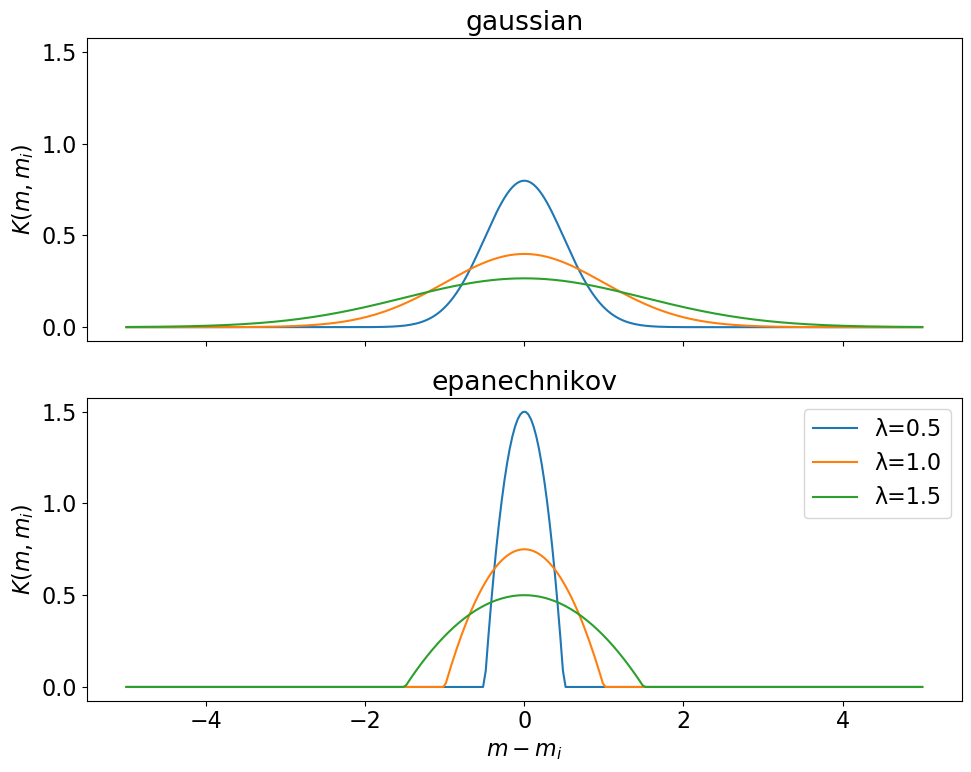

PyObject <matplotlib.legend.Legend object at 0x0000000021C717B8>

In [7]:
function K(m::Float64, mᵢ::Float64, λ::Float64, wut_kernel::String)
    # the distance between m and mᵢ, normalized by bandwidth, scaled
    u = ((m - mᵢ) / λ) ^ 2
    if wut_kernel == "gaussian"
        return exp(-u / 2) / sqrt(2 * π * λ ^ 2)
    elseif wut_kernel == "epanechnikov"
        if u < 1.0
            return 3 / 4 * (1 - u) / λ
        else
            return 0.0
        end
    else # not implemented
        return NaN
    end
end

m = 0.0
mᵢs = range(-5.0, stop=5.0, length=300)
λs = [0.5, 1.0, 1.5]

fig, axs = subplots(2, 1, figsize=(10, 8), 
                    sharex=true, sharey=true, tight_layout=true)

for λ in λs
    for (i, kernel_type) in enumerate(["gaussian", "epanechnikov"])
        k = [K(m, mᵢ, λ, kernel_type) for mᵢ in mᵢs]
        axs[i].plot(mᵢs, k, label="λ=$λ")
        axs[i].set_title(kernel_type)
        axs[i].set_ylabel(L"$K(m, m_i)$")
    end
end
xlabel(L"$m-m_i$")
legend()

## kernel density estimation

The kernel density estimation of the probability density $f(m)$ based on the sample data $m_1, m_2, ..., m_n$ is:
\begin{equation}
    \hat{f}_\lambda(m) = \frac{1}{n}\displaystyle \sum_{i=1}^n K_\lambda(m, m_i)
\end{equation}

To estimate the density at $m$, we add up the kernel of $m$ with all other data points. If $m$ is close to many data points ("close" determined by the kernel and, mostly, its bandwidth), the sum will "pile up" a lot of density at $m$ from the nearby "smeared out" data points and yield a high density. if $m$ is far from most data points, then the kernel of $m$ with the data points $m_i$ will be small or zero and little density will "pile up" at $m$.

A well-state description of KDE [here](http://compdiag.molgen.mpg.de/docs/talk_05_01_04_stefanie.pdf). To estimate the probability density:
* the center of the kernel is placed right over each data point
* the influence of each data point is spread out over its neighborhood (determined by the bandwidth of the kernel)
* the contribution from each data point to the density is summed to obtain the overall density estimate

Let's write our own KDE function that takes in:
* `m`: the mass at which we aim to estimate the density
* `m_sample`: the array of masses we sampled
* `λ`: the kernel bandwidth
* `wut_kernel`: which kernel we should use ("gaussian" or "epanechnikov")

and returns the kernel density estimate at `m`.

In [8]:
function corys_kde(m::Float64, m_sample::Array{Float64}, λ::Float64, wut_kernel::String)
    density_estimate = 0.0
    for i = 1:length(m_sample)
        density_estimate += K(m, m_sample[i], λ, wut_kernel)
    end
    return density_estimate / length(m_sample)
end

m = 100.0 # estimate the density here
λ = 10.9 # bandwidth
corys_kde(m, df[:, :mass], λ, "gaussian")

0.020605031170185327

finally, let's use our function to estimate the data generating distribution $f(m)$ from our sample. we'll use both kernels, Gaussian and Epanechnikov, so we can compare.

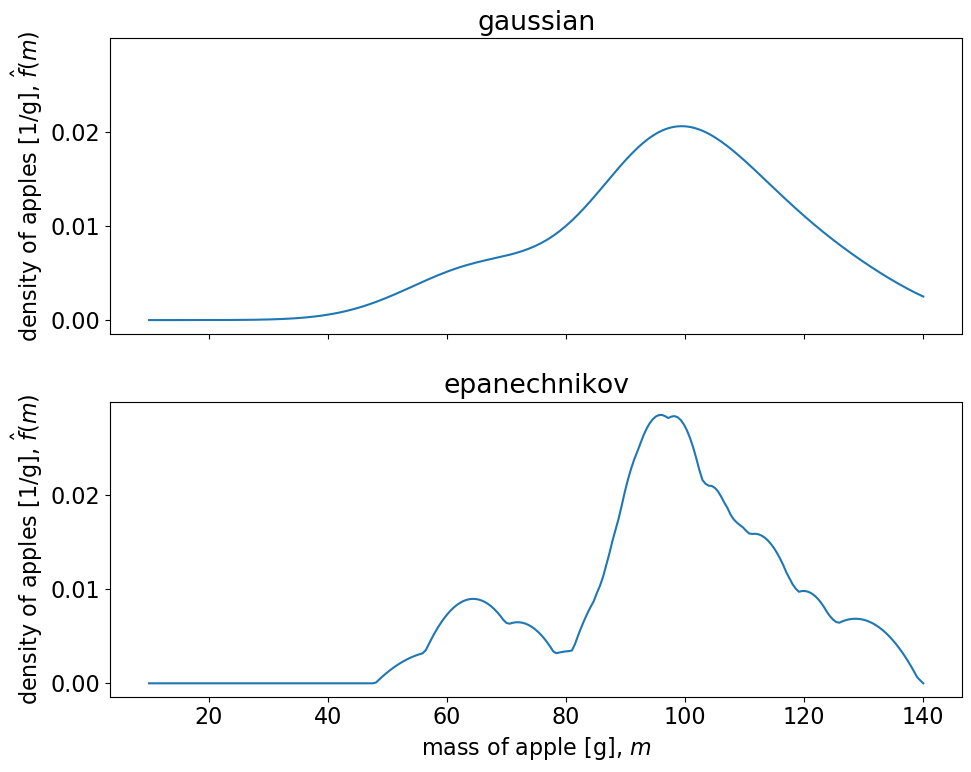

PyObject Text(0.5, 37.0, 'mass of apple [g], $m$')

In [9]:
# define apple masses at which we want to estimate the density (purely for visualization)
masses = range(10.0, stop=140.0, length=250)

# do the KDE
fig, axs = subplots(2, 1, figsize=(10, 8), 
                    sharex=true, sharey=true, tight_layout=true)

for (i, wut_kernel) in enumerate(["gaussian", "epanechnikov"])
    # do KDE with this kernel
    ρ = [corys_kde(mass, df[:, :mass], λ, wut_kernel) for mass in masses]
    # plot estimated densities vs. masses
    axs[i].plot(masses, ρ)
    axs[i].set_ylabel(L"density of apples [1/g], $\hat{f}(m)$")
    axs[i].set_title(wut_kernel)
end
xlabel(L"mass of apple [g], $m$")

## using the estimated probability density
aside from visualizing the estimated data generating distribution, we can use it to answer questions, such as:

what is the probability that a randomly drawn apple from the orchard has a mass of less than 80 g?

\begin{equation}
\text{Pr}(M<80)=\int_0^{80} f(m)dx
\end{equation}

We can do this integration via Monte Carlo integration!
\begin{equation}
\int_0^{80} f(m)dx =80\frac{1}{80} \int_0^{80} f(m)dm = 80 \langle f(m) \rangle_{(0,80)}
\end{equation}

In [10]:
nb_samples = 1000 # number of Monte Carlo samples for the integration

avg_f = 0.0 # will be ⟨f⟩
# collect random samples of f(m) in m [0, 80]
for s = 1:nb_samples
    # sample a mass from 0 to 80
    mass = rand() * 80 # uniform number in [0, 80]
    avg_f += corys_kde(mass, df[:, :mass], λ, "gaussian")
end
avg_f / nb_samples * 80

0.189712824201527

## how to choose the bandwidth?
* bandwidth too large => oversmoothed density (data points smeared out so much that you lose the features of the underlying distribution)
* bandwidth too small => undersmoothed density (you see features in your density estimate that are not truly present in the underlying distribution)

$\lambda=1.0$: jagged features in the distribution that are [probably] not there<br>
$\lambda=15.0$: smooth out data to the extent that you don't see bimodality<br>
$\lambda=8.0$: just right, we see bimodality

there are several methods for choosing the bandwidths... we will do this in class later when we do cross-validation.

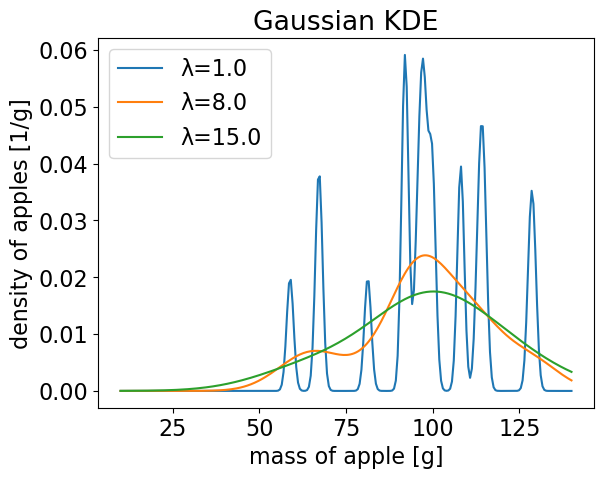

PyObject <matplotlib.legend.Legend object at 0x0000000001B51D30>

In [11]:
λs = range(1.0, stop=15.0, length=3)
wut_kernel = "gaussian"

for λ in λs
    # do KDE with this kernel
    ρ = [corys_kde(mass, df[:, :mass], λ, wut_kernel) for mass in masses]
    # plot estimated densities vs. masses
    plot(masses, ρ, label="λ=$λ")
end
xlabel("mass of apple [g]")
title("Gaussian KDE")
ylabel("density of apples [1/g]")
legend()

Silverman's rule of thumb (for one-dimensional data) for the bandwidth [[source](http://www.buch-kromann.dk/tine/nonpar/Nonparametric_Density_Estimation_multidim.pdf)]:

\begin{equation}
    \lambda = \biggl(\frac{4\hat{\sigma}^5}{3n} \biggr)^{1/5}
\end{equation}
where $n$ is the number of data points, $\hat{\sigma}$ is the standard deviation of the data. 

In [12]:
λ_silverman = (4 * std(df[:, :mass]) ^ 5 / (3 * nrow(df))) ^ (1 / 5)

10.911747572936896

## scikit-learn for KDE

the package `scikitlearn`, which we call from Python, allows us to do kernel density estimation with a variety of kernels. see the documentation [here](https://scikit-learn.org/stable/modules/density.html)

here is how we import scikit-learn functions into Julia.

In [13]:
@sk_import neighbors.kde : KernelDensity

┌ Info: Installing sklearn via the Conda scikit-learn package...
└ @ PyCall C:\Users\Owner\.julia\packages\PyCall\ttONZ\src\PyCall.jl:705
┌ Info: Running `conda install -y scikit-learn` in root environment
└ @ Conda C:\Users\Owner\.julia\packages\Conda\kLXeC\src\Conda.jl:112


Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\Owner\.julia\conda\3

  added / updated specs:
    - scikit-learn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.10.16 |                0         163 KB
    joblib-0.13.2              |           py36_0         339 KB
    openssl-1.1.1d             |       he774522_3         5.7 MB
    scikit-learn-0.21.3        |   py36h6288b17_0         4.4 MB
    scipy-1.3.1                |   py36h29ff71c_0        11.3 MB
    ------------------------------------------------------------
                                           Total:        21.9 MB

The following NEW packages will be INSTALLED:

  joblib             pkgs/main/win-64::joblib-0.13.2-py36_0
  scikit-learn       pkgs/main/win-64::scikit-learn-0.21.3-py36h6288b17_0
  scipy              pkgs/main/win-64::scipy-1.3.1-py36h2

PyObject <class 'sklearn.neighbors.kde.KernelDensity'>

now, let's do kernel density estimation in scikitlearn with a Gaussian kernel and the same bandwidth `λ` as above. first, construct a `KernelDensity` object.

In [14]:
kde = KernelDensity(kernel="gaussian", bandwidth=λ)

PyObject KernelDensity(algorithm='auto', atol=0, bandwidth=10.9, breadth_first=True,
              kernel='gaussian', leaf_size=40, metric='euclidean',
              metric_params=None, rtol=0)

next, we need to put our data in a format that scikitlearn needs. although our samples are scalars, we need to represent them as 1D vectors for scikitlearn. scikitlearn's `KernelDensity` object was designed with high-dimensional data in mind. so to make our sampled masses an array of 1D arrays for scikitlearn:

In [15]:
sample_masses = [[row[:mass]] for row in eachrow(df)]

20-element Array{Array{Float64,1},1}:
 [108.20535675585407]
 [92.11445827312127] 
 [107.95894817321351]
 [58.87711063761283] 
 [100.10360270241122]
 [67.44315510523454] 
 [92.14622115463766] 
 [129.096902994266]  
 [96.72133629711364] 
 [66.9553570753678]  
 [99.59985147205123] 
 [128.11149783031908]
 [97.20868238556788] 
 [81.27085357175854] 
 [98.01357496629956] 
 [113.1726581261136] 
 [91.82359854827018] 
 [95.53643088149084] 
 [114.20489522388259]
 [114.88416683301007]

next, we pass scikitlearn the sampled data, via the "fit" function associated with the `KernelDensity` object.

In [16]:
kde.fit(sample_masses)

PyObject KernelDensity(algorithm='auto', atol=0, bandwidth=10.9, breadth_first=True,
              kernel='gaussian', leaf_size=40, metric='euclidean',
              metric_params=None, rtol=0)

finally, we can score new samples, i.e. estimate the density at a different location in feature space. to estimate the density at 100 g, i.e. to estimate $f(100)$, we again need to represent our sample as an array of arrays (this could take multiple samples as input.

we also need to exponentiate the result because scikitlearn returns the *log* of the density.

**warning:** scikitlearn's `KernelDensity.score_samples()` returns the `log` of the density.

In [17]:
ρ_at_100g = exp.(kde.score_samples([[100.0]]))

1-element Array{Float64,1}:
 0.020605031170185327

compare this to our KDE function; we get the same thing! so we succesfully reproduced scikitlearn's KDE module.

In [18]:
corys_kde(100.0, df[:, :mass], λ, "gaussian")

0.020605031170185327

to be sure, let's plot the kernel density estimate of $f(m)$ from scikitlearn using the Gaussian and Epanechnikov kernels and ensure they are the same as ours. Indeed!

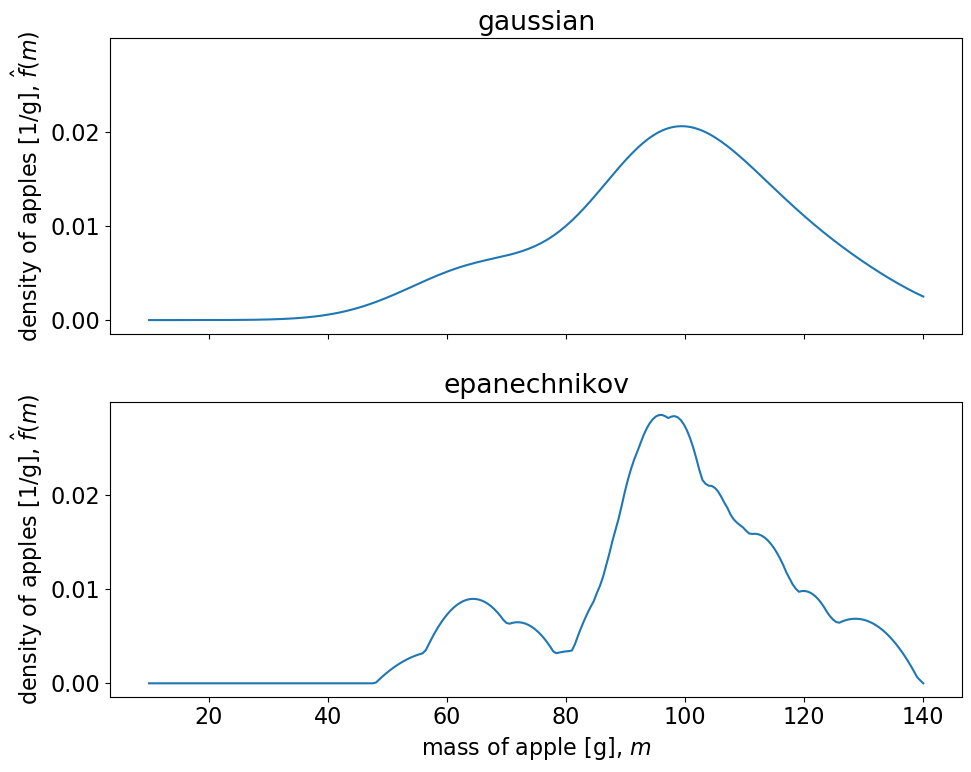

PyObject Text(0.5, 37.0, 'mass of apple [g], $m$')

In [19]:
# do the KDE
fig, axs = subplots(2, 1, figsize=(10, 8), 
                    sharex=true, sharey=true, tight_layout=true)

for (i, wut_kernel) in enumerate(["gaussian", "epanechnikov"])
    #
    # use scikit-learn for KDE
    #
    # construct KernelDenstiy object. tell it kernl and bandwidth to use
    kde = KernelDensity(kernel=wut_kernel, bandwidth=λ)
    # write sample as an array of arrays (to accommodate format of higher dimensional data)
    sample_masses = [[row[:mass]] for row in eachrow(df)]
    # pass the KernelDensity object the data, "fit"
    kde.fit(sample_masses)
    # estimate the denstiy at our specified `masses`. 
    # this returns the log of the density so need to exponentiate
    ρ = exp.(kde.score_samples([[mass] for mass in masses]))
    
    # plot estimated densities vs. masses
    axs[i].plot(masses, ρ)
    axs[i].set_ylabel(L"density of apples [1/g], $\hat{f}(m)$")
    axs[i].set_title(wut_kernel)
end
xlabel(L"mass of apple [g], $m$")

## KDE in multiple dimensions

e.g. theft from vehicles in Vancouver, Canada. the raw data consist of geo-coordinates of theft from vehicles.

<img src="https://1.bp.blogspot.com/-8e1KvRfOJL4/Wf2YTkr4VrI/AAAAAAAAApo/6JtI6MOO7moJjdkkoz6ESl5PZTGKjg0OACLcBGAs/s1600/crime-heatmap-vancouver-color.png" width=500>

## Old Faithful (2D KDE)

>      Waiting time between eruptions and the duration of the eruption
     for the Old Faithful geyser in Yellowstone National Park, Wyoming,
     USA. A data frame with 272 observations on 2 variables. 
     
[source](https://www.stat.cmu.edu/~larry/all-of-statistics/=data/faithful.dat)

<img src="https://upload.wikimedia.org/wikipedia/commons/8/80/OldFaithful1948.jpg" width=200>

In [20]:
df = CSV.read("faithful.dat", datarow=27, header=26, delim=" ", ignorerepeated=true)
df = df[:, [:eruption, :waiting]]
first(df, 6)

ArgumentError: ArgumentError: "faithful.dat" is not a valid file

In [21]:
figure()
scatter(df[:, :eruption], df[:, :waiting], marker="x")
xlabel("eruption time [min]")
ylabel("waiting time [min]")
title("old faithful data")

ArgumentError: ArgumentError: column name :eruption not found in the data frame

2D KDE in Scikitlearn is painful because it only allows us to supply a scalar value for $\lambda$, whereas the scale for the eruption time and waiting time is different. we would have to scale the data so one can use a radially symmetric Gaussian kernel as scikitlearn offers.

instead, we can use [Seaborn](https://seaborn.pydata.org/), a Python package built on top of matplotlib.

Seaborn automatically chooses the bandwidth using Scott's rule.

In [22]:
using PyCall
seaborn = pyimport("seaborn")

ArgumentError: ArgumentError: Package PyCall not found in current path:
- Run `import Pkg; Pkg.add("PyCall")` to install the PyCall package.


In [23]:
seaborn.kdeplot(df[:, :eruption], df[:, :waiting], shade=true, bw="scott")
scatter(df[:, :eruption], df[:, :waiting], marker="x")
xlabel("eruption time [min]")
ylabel("waiting time [min]")

ArgumentError: ArgumentError: column name :eruption not found in the data frame

check out the [Seaborn Gallery](https://seaborn.pydata.org/examples/index.html). We can make a plot that shows the kernel density estimation in feature space as well as a kernel density estimation of the marginal distributions on the side.

`seaborn.jointplot` returns an object that has `ax_joint` as an attribute. This is a matplotlib axis on which we can draw.

In [24]:
p = seaborn.jointplot(df[:, :eruption], df[:, :waiting], kind="kde")
p.ax_joint.set_xlabel("eruption time [min]")
p.ax_joint.set_ylabel("waiting time [min]")
p.ax_joint.scatter(df[:, :eruption], df[:, :waiting], marker="o", s=2)

ArgumentError: ArgumentError: column name :eruption not found in the data frame

## seaborn 1D KDE

In [25]:
df = CSV.read("apples.csv")

seaborn.kdeplot(df[:, :mass], bw="silverman", shade=true)
seaborn.rugplot(df[:, :mass])
xlabel(L"mass of apple [g], $m$")
ylabel(L"density [1/g], $\hat{f}(m)$")

UndefVarError: UndefVarError: seaborn not defined